## Numerical considerations for spectral timing models

Converting models from the time to the Fourier domain comes with a long list of numerical issues that users need to be mindful of. It is extremely important that users are mindful of these limitations when they are setting up any model. For a longer description of various numerical effects impacting the Fast Fourier Transform, we refer users to van der Klis 1989. 

In [1]:
#we begin by importing a standard set of libraries:
import sys
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

from ndspec.Timing import PowerSpectrum, CrossSpectrum
import ndspec.models as models

The first well known consideration is that we need to be mindful of which Fourier frequencies our time series can actually sample. We begin with three time grids with different length and sampling to illustrate this.

The first grid, labelled ````coarse````, is a grid of 1000 units of time, made up of 2500 bins. The second grid, labelled ````short````, has an equal number of bins, but only extends to 100 time units. The third grid, ````high````, once again samples 1000 time units, but at a finer resolution, and uses 7500 bins. For each of these three grids we instatiate a ````PowerSpectrum```` and initialize a model with two Lorentizan functions for it; each model is computed on the Fourier frequency grid corresponding to the time grid. When we plot the power spectrum from each objects, we see that the frequency range covered by each is different. 

First, ````coarse```` and ````high```` extend to a minimum frequency of $\nu_{min} = 10^{-3}$ Hz, while ````short```` only extends down to $\nu_{min} = 10^{-2}$ Hz. This is because the lowest Fourier frequency that can be probed is $1/t_{max}$, where $t_{max}$ is the longest time in each time grid - 1000 for ````coarse```` and ````high````, and 100 for ````short````.

Second, the maximum frequency of each object is also limited by the Nyquist frequency, which is defined as $1/2 dt$, where $dt$ is the width of the finest bin in the time grid. Using ````coarse```` as an example, $dt = 1000/2500 = 0.4$ and therefore $\nu_{max} = 1.25$ Hz. ````high```` uses finer binning by a factor 3 compared to ````coarse````, and therefore $\nu_{max} = 3*1.25 = 3.75$ Hz. Finally, ````high```` uses the same 2500 bins to sample one order of magnitude less in time than ````coarse````, and therefore $\nu_{max} = 10*1.25 
= 12.5$ Hz. These limits are marked in the plot by vertical lines of the appropriate color.

For powerspectra setting up appropriate time/frequency grid is comparatively straightforward, but as we will show later, these lower and upper limits on the frequencies probed can have a deep impact on the products computed from cross spectra.

30

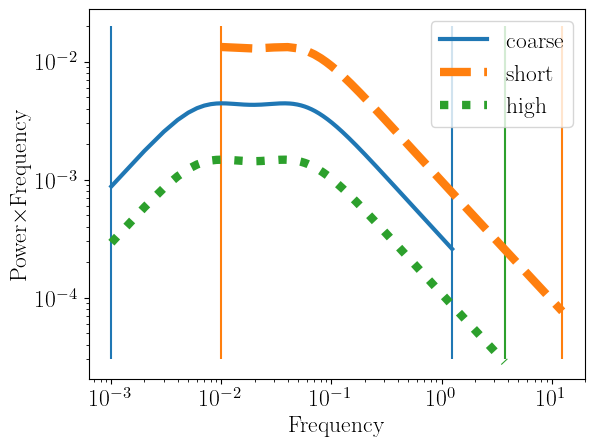

In [2]:
#define three numerical grids of times
ntimes = 2500
times_coarse = np.linspace(0.1,1.e3,ntimes)
times_short = np.linspace(0.1,1.e2,ntimes)
ntimes = 7500 
times_high = np.linspace(0.1,1.e3,ntimes)

#instantiate a PowerSpectrum for each of these; when doing so, the correspdonding Fourier frequency grid
#is computed automatically
psd_coarse = PowerSpectrum(times_coarse)
psd_short = PowerSpectrum(times_short)
psd_high = PowerSpectrum(times_high)

#Define our model for the power spectrum directly in Fourier space, as a sum of two Lorentzians
centroid_1 = 0.0075
q_1 = 0.1
rms_1 = 0.1
centroid_2 = 0.05
q_2 = 0.1
rms_2 = 0.1
model_coarse = models.lorentz(psd_coarse.freqs,np.array([centroid_1,q_1,rms_1])) + \
              models.lorentz(psd_coarse.freqs,np.array([centroid_2,q_2,rms_2]))
model_short = models.lorentz(psd_short.freqs,np.array([centroid_1,q_1,rms_1])) + \
              models.lorentz(psd_short.freqs,np.array([centroid_2,q_2,rms_2]))
model_high = models.lorentz(psd_high.freqs,np.array([centroid_1,q_1,rms_1])) + \
              models.lorentz(psd_high.freqs,np.array([centroid_2,q_2,rms_2]))


#Assign the model array to power_spec and plot the result
psd_coarse.power_spec = model_coarse
psd_short.power_spec = model_short
psd_high.power_spec = model_high

plt.vlines(1/1e3,ymin=3e-5,ymax=2e-2,color='C0')
plt.vlines(1/1e2,ymin=3e-5,ymax=2e-2,color='C1')
plt.vlines(0.5/np.diff(times_coarse)[0],ymin=3e-5,ymax=2e-2,color='C0')
plt.vlines(0.5/np.diff(times_short)[0],ymin=3e-5,ymax=2e-2,color='C1')
plt.vlines(0.5/np.diff(times_high)[0],ymin=3e-5,ymax=2e-2,color='C2')

#we rescale the second and third the models up/down for visual clarity
plt.plot(psd_coarse.freqs,psd_coarse.power_spec*psd_coarse.freqs,
         lw=3,label='coarse')
plt.plot(psd_short.freqs,3*psd_short.power_spec*psd_short.freqs,
         lw=6,label='short',linestyle='dashed')
plt.plot(psd_high.freqs,0.333*psd_high.power_spec*psd_high.freqs,
         lw=6,label='high',linestyle='dotted')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency")
plt.ylabel("Power$\\times$Frequency")
plt.legend()
gc.collect()

Let us now set up three ````CrossSpectrum```` object using a phenomenological impulse response function, over the NICER energy grid, and using the same three time grids as before. For each we will use the same shape of the input power spectrum, reference band, parameters etc:

In [3]:
#read the NICER response to set up an identical energy array
NICER_rmf = os.getcwd()+"/data/nicer-rmf6s-teamonly-array50.rmf"
response = fits.open(NICER_rmf)
# get all the extension names
extnames = np.array([h.name for h in response])
if "MATRIX" in extnames:
    h = response["MATRIX"]
elif "SPECRESP MATRIX" in extnames:
    h = response["SPECRESP MATRIX"]
data = h.data
energ_lo = np.array(data.field("ENERG_LO"))
energ_hi = np.array(data.field("ENERG_HI"))
nicer_en = (energ_lo+energ_hi)/2.
energy_channels=len(nicer_en)
response.close()
ref_emin = nicer_en[0]
ref_emax = nicer_en[-1]

#First: define a reverberation model
gauss_coarse, gauss_line, gauss_pulse = models.gauss_bkn(times_coarse,nicer_en,np.array([3e-2,2,6.5,2,-3,4,-0.25]))

bb_coarse, bb_spec, bb_pulse = models.bbody_bkn(times_coarse,nicer_en,np.array([1.5e-3,0.5,2,-3,4,-0.25]))

gauss_short, gauss_line, gauss_pulse = models.gauss_bkn(times_short,nicer_en,np.array([3e-2,2,6.5,2,-3,4,-0.25]))

bb_short, bb_spec, bb_pulse = models.bbody_bkn(times_short,nicer_en,np.array([1.5e-3,0.5,2,-3,4,-0.25]))

gauss_high, gauss_line, gauss_pulse = models.gauss_bkn(times_high,nicer_en,np.array([3e-2,2,6.5,2,-3,4,-0.25]))

bb_high, bb_spec, bb_pulse = models.bbody_bkn(times_high,nicer_en,np.array([1.5e-3,0.5,2,-3,4,-0.25]))

mod_coarse = gauss_coarse + bb_coarse
mod_short = gauss_short + bb_short
mod_high = gauss_high + bb_high

#define three cross spectra
rev_coarse = CrossSpectrum(times_coarse,energ=nicer_en)
rev_coarse.set_psd_weights(psd_coarse.power_spec)
rev_coarse.set_impulse(mod_coarse)
rev_coarse.set_reference_energ([ref_emin,ref_emax])
rev_coarse.cross_from_irf()

rev_short = CrossSpectrum(times_short,energ=nicer_en)
rev_short.set_psd_weights(psd_short.power_spec)
rev_short.set_impulse(mod_short)
rev_short.set_reference_energ([ref_emin,ref_emax])
rev_short.cross_from_irf()

rev_high = CrossSpectrum(times_high,energ=nicer_en)
rev_high.set_psd_weights(psd_high.power_spec)
rev_high.set_impulse(mod_high)
rev_high.set_reference_energ([ref_emin,ref_emax])
rev_high.cross_from_irf()

Let us first compare the behavior of the phase-frequency spectrum near the Nyquist frequency of each ````CrossSpectrum````, which we will once again mark with a vertical line. 

Again using ````coarse```` as an example, note that the phase lag tends towards zero at the Nyquist frequency, while ````short```` and ````high````, whose Nyquist frequencies are higher, do not. The same repeats when ````high```` is close to its maximum frequency. In other words, _near the Nyquist frequency the FFT algorithm is not describing the input signal well enough, and this causes the phases (and modulus) to be erroneous_. Furthermore, note that there is a discrepancy between the three cross spectra at frequencies lower than the Nyquist frequency by a factor of a few. 

The take away point from this exercise is this: if users are interested in a signal at a maximum frequency $\nu_{hi}$, they should set up their model grids such that the Nyquist frequency reaches $\approx$ a few $\nu_{hi}$ at least.

13090

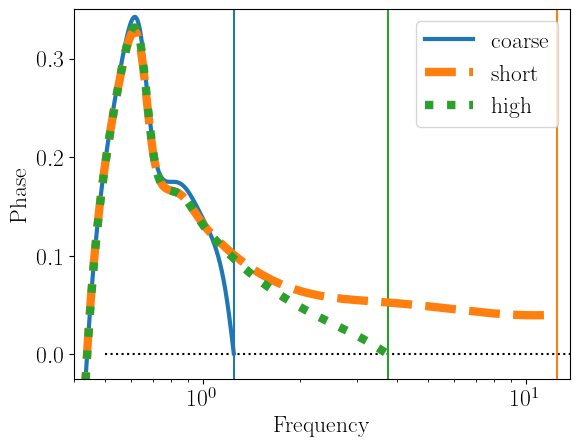

In [4]:
#define some bounds for the channel of interest for simplicity
bounds = [3.,5.]

plt.hlines(0,xmin=0.5,xmax=1.1*rev_short.freqs[-1],
           color='black',linestyle='dotted')

plt.vlines(0.5/np.diff(times_coarse)[0],ymin=-0.025,ymax=0.35,color='C0')
plt.vlines(0.5/np.diff(times_short)[0],ymin=-0.025,ymax=0.35,color='C1')
plt.vlines(0.5/np.diff(times_high)[0],ymin=-0.025,ymax=0.35,color='C2')

plt.plot(rev_coarse.freqs,rev_coarse.lag_frequency(bounds),
         lw=3,label='coarse')
plt.plot(rev_short.freqs,rev_short.lag_frequency(bounds),
          lw=6,linestyle='dashed',label='short')
plt.plot(rev_high.freqs,rev_high.lag_frequency(bounds),
          lw=6,linestyle='dotted',label='high')

plt.xlim([0.4,1.1*rev_short.freqs[-1]])
plt.ylim([-0.025,0.35])
plt.xscale("log")
plt.xlabel("Frequency")
plt.ylabel("Phase")
plt.legend()
gc.collect()

Let us now look at what happens at lower Fourier frequencies, by plotting the 2d cross spectra from our ````high```` and ````short```` grids. As discussed earlier, the frequency range over which the two cross spectra are defined extends to different lower bounds. 

A more important consideration is that that the frequency grids are very coarse near their lower bound. This is a straightforward consequence of using a Fast Fourier Transform, which requires a linearly spaced input time signal. As a result, the Fourier frequency grid is also linearly spaced, and therefore appears coarse when plotted over a log axis. Increasing the number of bins, as was done for ````high```` mitigates this issue somewhat but not entirely. 

Similarly to before, the take away point is this: if users are interested in a signal at some low frequency $\nu_{low}$, they will likely need to set up a finely enough spaced grid that the signal is sampled over multiple frequency bins.

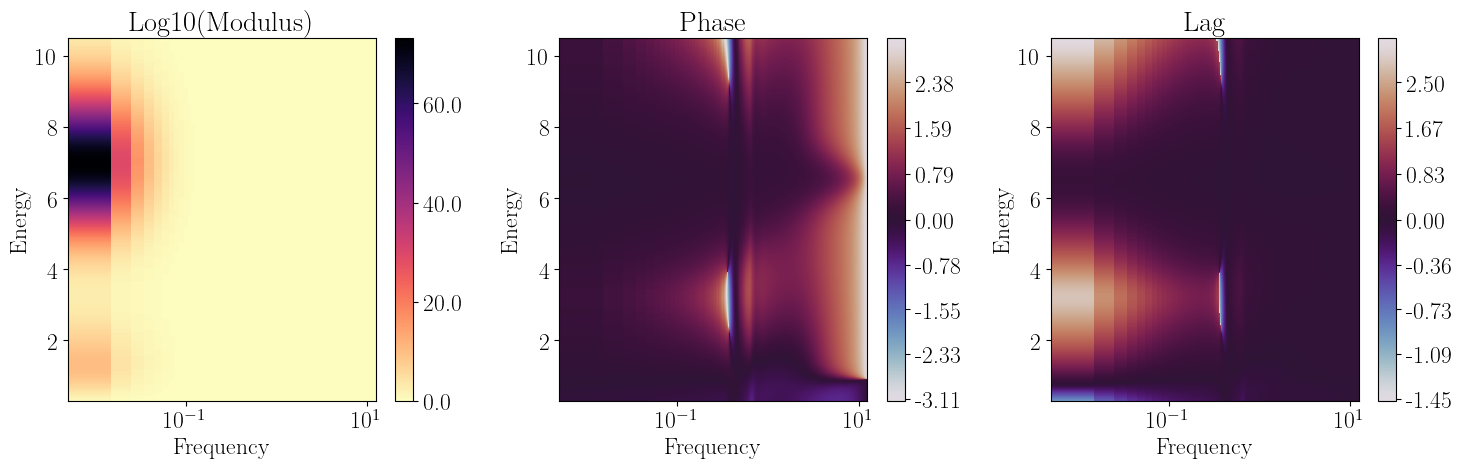

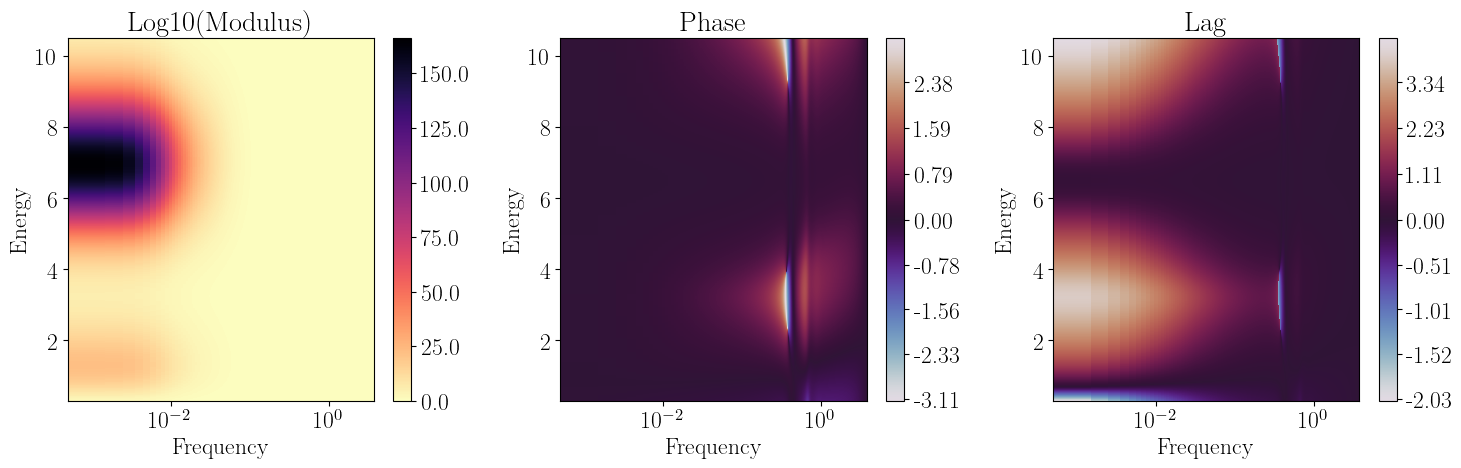

38348

In [5]:
#low frequency sampling
rev_short.plot_cross_2d()
rev_high.plot_cross_2d()
gc.collect()

Quite commonly, a model might need to sample finely a large range of time scales, and therefore Fourier frequencies. In this case, both the conditions above apply: we need a very finely sampled time series (to have a large Nyquist frequency), and a very long one (to effectively sample low Fourier frequencies). This will result in a very large computational time required for each model instance, should we use a FFT to compute the cross spectrum.

In nDspec, this problem can be avoided by not using a FFT at all. Instead, one can use the sinc decomposition method from Uttley and Malzac (2023). With this method, we assume that the impulse response function is constant across each time bin. In this case, it can be shown that the impulse response function can be decomposed into a series of sinc functions centered at each Fourier frequency bin, with a phase shift corresponding to the time delay. This is true for any grid of time and Fourier frequency bins, rather than just linear ones. This allows us to define time and Fourier frequency grids with, for example, logarithmic rather than linear spacing.

As an example, let us define two logarithmically spaced grids of time and Fourier frequency, starting and ending at the same range as our ````coarse```` grid from above. We can then initialize a ````CrossSpectrum````, and specify the logarithmic frequency array with the ````freqs```` keyword as well as the sinc method with the ````method```` keyword. 

Plotting both our new ````sinc```` ````CrossSpectrum````, along with ````coarse````, we clearly see that the former focuses the resolution more smoothly across Fourier frequencies, while at the same time returning essentially identical results.

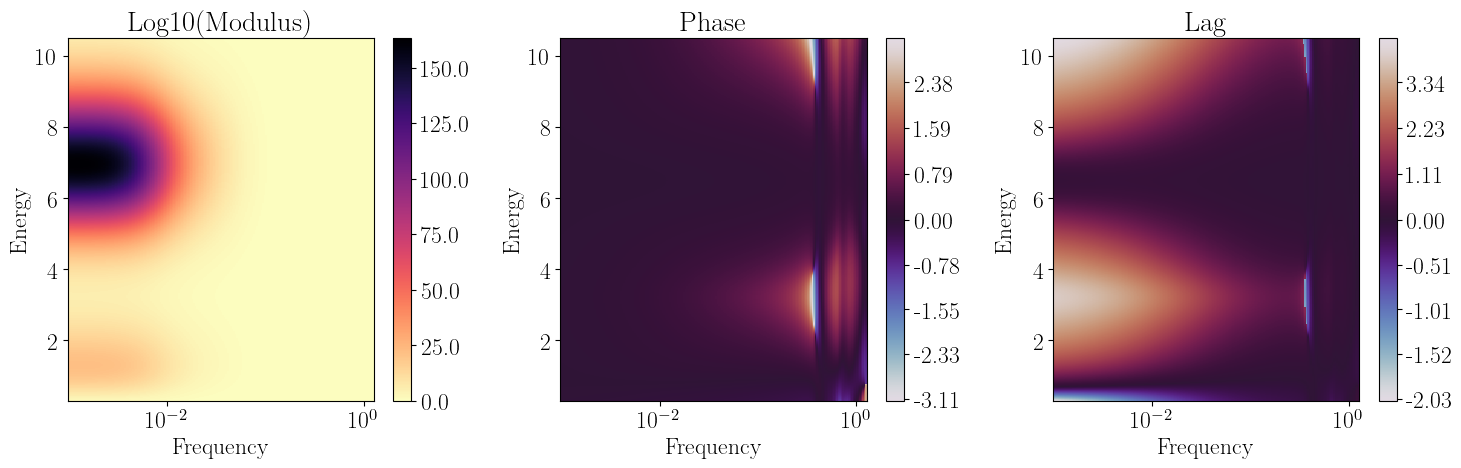

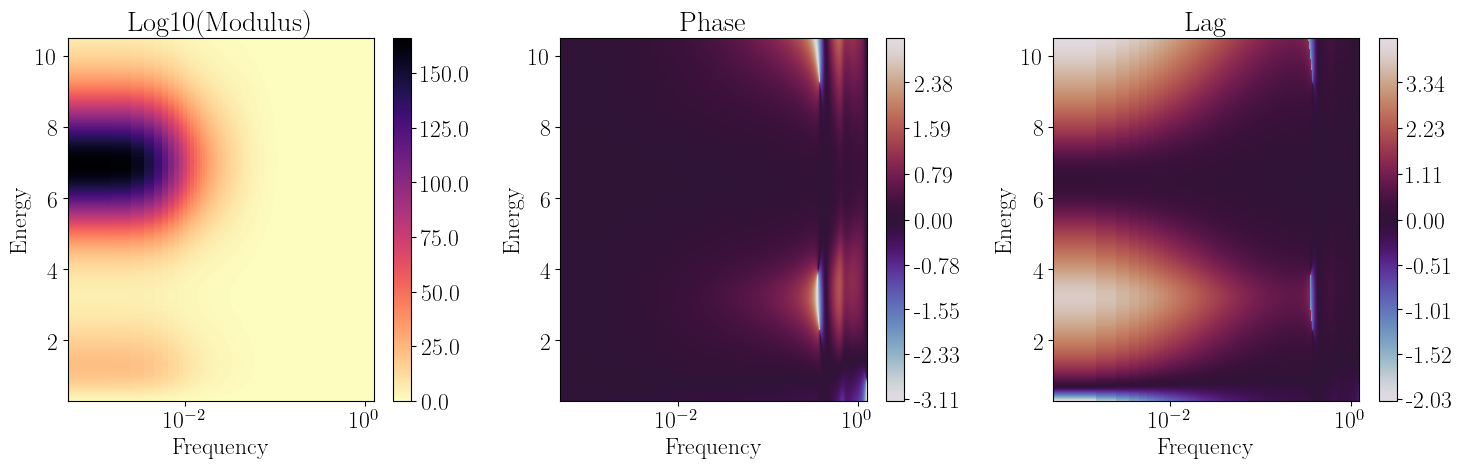

31489

In [6]:
#create logarithmically spaced grids in time and frequency
sinc_tstart = np.log10(times_coarse[0])
sinc_tend = np.log10(times_coarse[-1])
sinc_fstart = np.log10(rev_coarse.freqs[0])
sinc_fend = np.log10(rev_coarse.freqs[-1])
times_sinc = np.logspace(sinc_tstart,sinc_tend,500)
freqs_sinc = np.logspace(sinc_fstart,sinc_fend,200)

#define the power spectrum and impulse response functions as before, over the new frequency grid
psd_sinc = models.lorentz(freqs_sinc,np.array([centroid_1,q_1,rms_1])) + \
           models.lorentz(freqs_sinc,np.array([centroid_2,q_2,rms_2]))

gauss_sinc, gauss_line, gauss_pulse = models.gauss_bkn(times_sinc,nicer_en,np.array([3e-2,2,6.5,2,-3,4,-0.25]))
bb_sinc, bb_spec, bb_pulse = models.bbody_bkn(times_sinc,nicer_en,np.array([1.5e-3,0.5,2,-3,4,-0.25]))
mod_sinc = gauss_sinc + bb_sinc

#Initialize the new cross spectrum
rev_sinc = CrossSpectrum(times_sinc,freqs=freqs_sinc,energ=nicer_en,method='sinc')
rev_sinc.set_psd_weights(psd_sinc)
rev_sinc.set_impulse(mod_sinc)
rev_sinc.set_reference_energ([ref_emin,ref_emax])
rev_sinc.cross_from_irf()

#plot the new cross spectrum and plot it, along with the coarse one for comparison
rev_sinc.plot_cross_2d()
rev_coarse.plot_cross_2d()
gc.collect()

Let us now compare the behavior of both methods at high frequencies. As before, we will start with the cross spectrum phase as a function of Fourier frequency. The sinc and FFT methods generally behave similarly; note that regardless of method, near the Nyquist frequency the phase becomes zero. In other words, similarly to the FFT, the sinc decomposition fails to describe the input signal near the Nyquist frequency. Regardless of method, users have to be careful in how they set up the numerical grids for their models. 

50

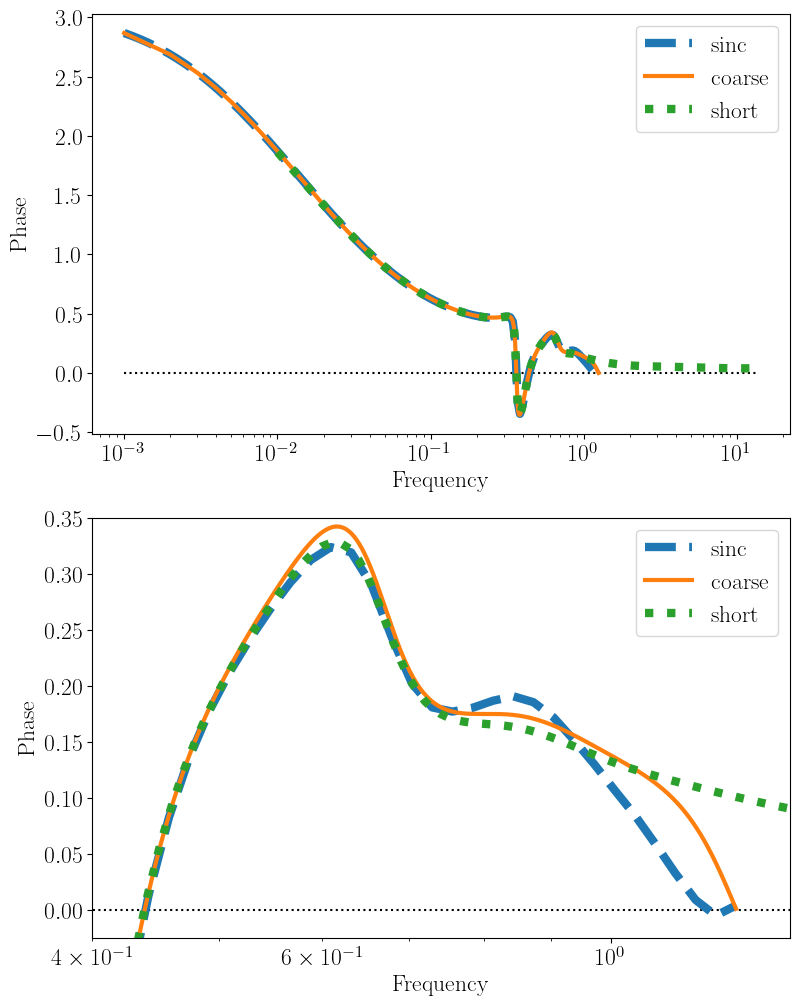

In [7]:
fig, ((ax1,ax2)) = plt.subplots(2,1,figsize=(9.,12.))

ax1.hlines(0,xmin=rev_sinc.freqs[0],xmax=1.1*rev_short.freqs[-1],
           color='black',linestyle='dotted')
ax1.plot(rev_sinc.freqs,rev_sinc.lag_frequency(bounds),
          lw=6,linestyle='dashed',label='sinc')
ax1.plot(rev_coarse.freqs,rev_coarse.lag_frequency(bounds),
         lw=3,label='coarse')
ax1.plot(rev_short.freqs,rev_short.lag_frequency(bounds),
         lw=6,linestyle='dotted',label='short')
ax1.set_xscale("log")
ax1.set_xlabel("Frequency")
ax1.set_ylabel("Phase")
ax1.legend()

ax2.hlines(0,xmin=rev_sinc.freqs[0],xmax=1.1*rev_sinc.freqs[-1],
           color='black',linestyle='dotted')

ax2.plot(rev_sinc.freqs,rev_sinc.lag_frequency(bounds),
          lw=6,linestyle='dashed',label='sinc')
ax2.plot(rev_coarse.freqs,rev_coarse.lag_frequency(bounds),
         lw=3,label='coarse')
ax2.plot(rev_short.freqs,rev_short.lag_frequency(bounds),
         lw=6,linestyle='dotted',label='short')
ax2.set_xscale("log")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Phase")
ax2.legend()
ax2.set_xlim([0.4,1.1*rev_sinc.freqs[-1]])
ax2.set_ylim([-0.025,0.35])
gc.collect()

The sinc decomposition method can be affected from numerical noise more severely than the FFT method, depending on the exact model and its input parameters. To show this, we are going to set up another phenomenological reverberation model, and plot the real and imaginary parts of the resulting cross spectrum as a function of Fourier frequency.

Two main features stand out. First (top row in the plot), at low Fourier frequencies, the imaginary part of the ````sinc```` cross spectrum appears to oscillate. This can happen near the lower bound of the Fourier frequency grid, and has a minor impact on the modulus of the cross spectrum (note that the imaginary part is roughly ten times smaller than the real part). Users can mitigate this issue by extending the Fourier frequency to lower values, and by increasing the number of frequency bins. Second (bottom row in the plot), after zooming in at high frequencies, we se both the real and imaginary parts of the ````sinc```` cross spectrum show noticeable numerical noise, while the coarse fft does not. Note that This numerical noise only appears near the Nyquist frequency, and lower frequencies are not affected.

15205

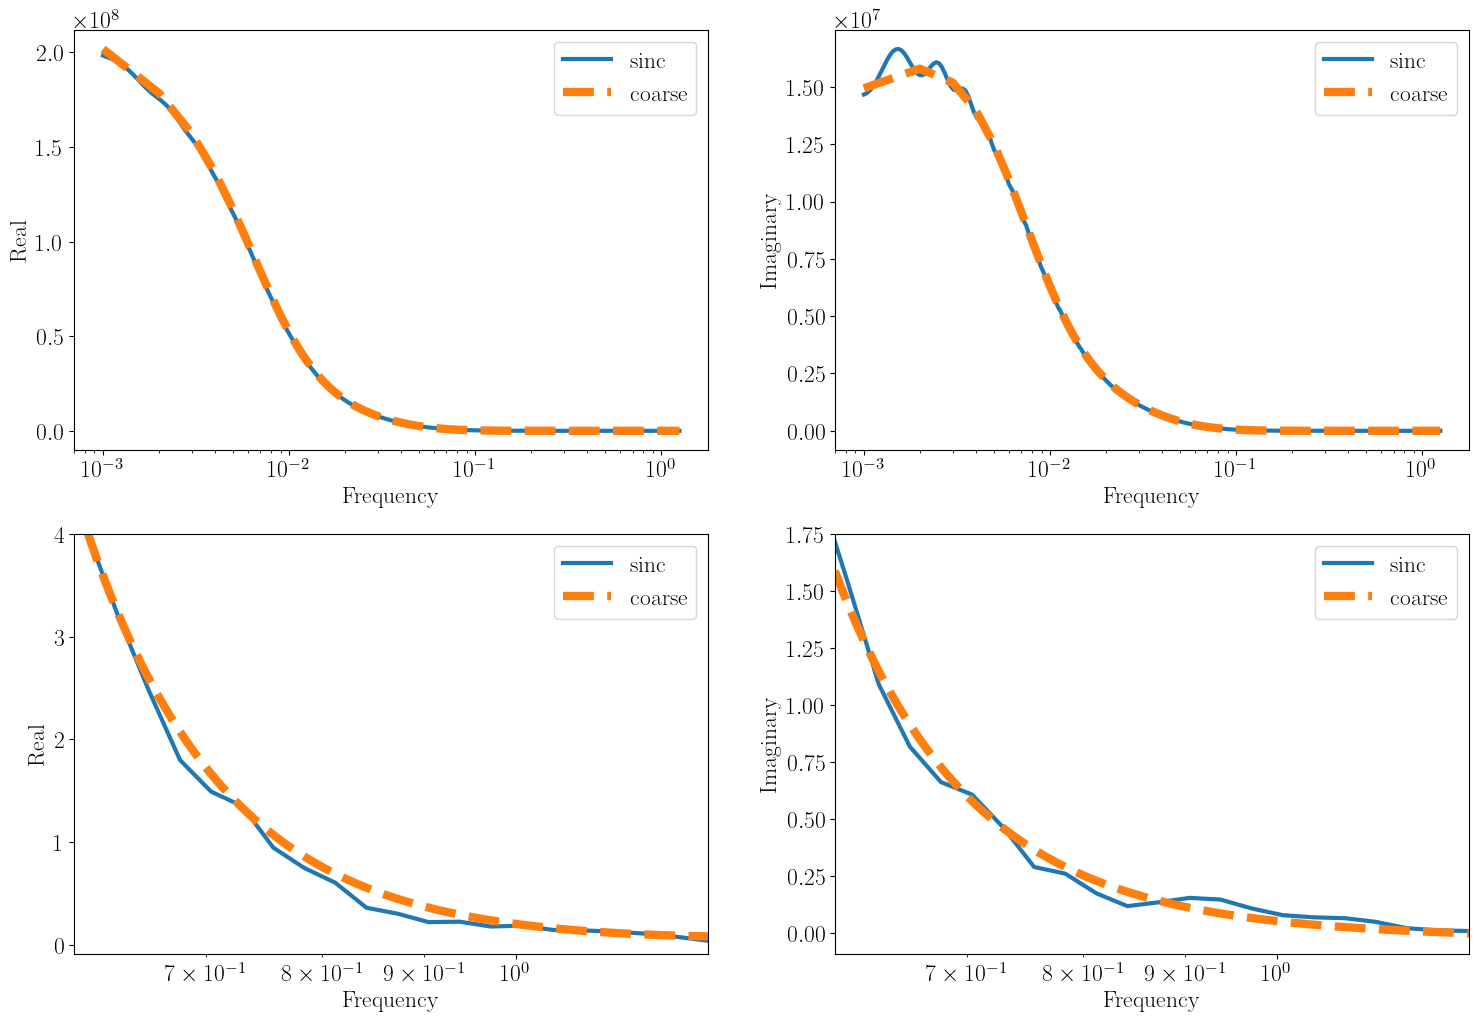

In [8]:
#set up another reverberation model with new parameters
bbflash_fft, bbspec, bbpulse = models.bbody_bkn(times_coarse,nicer_en,np.array([1.,0.5,1.,-1.5,3.,-0.05]))  
gauss_fft, gauss_line, gauss_pulse = models.gauss_bkn(times_coarse,nicer_en,np.array([1.,2,6.5,1,-1.5,3,-0.05]))

bbflash_new, bbspec, bbpulse = models.bbody_bkn(times_sinc,nicer_en,np.array([1.,0.5,1.,-1.5,3.,-0.05]))  
gauss_new, gauss_line, gauss_pulse = models.gauss_bkn(times_sinc,nicer_en,np.array([1.,2,6.5,1,-1.5,3,-0.05]))

revflash_fft = gauss_fft + bbflash_fft
revflash_new = gauss_new + bbflash_new

#calculate the cross spectra
cross_fft = CrossSpectrum(times_coarse,energ=nicer_en)
cross_fft.set_impulse(revflash_fft)
cross_fft.set_reference_energ([ref_emin,ref_emax])
cross_fft.set_psd_weights(psd_coarse.power_spec)
cross_fft.cross_from_irf()

cross_sinc = CrossSpectrum(times_sinc,freqs=freqs_sinc,energ=nicer_en,method='sinc')
cross_sinc.set_impulse(revflash_new)
cross_sinc.set_reference_energ([ref_emin,ref_emax])
cross_sinc.set_psd_weights(psd_sinc)
cross_sinc.cross_from_irf()

#plot the real and imaginary parts of the cross spectra, across the frequency range and zooming in near 
#the Nyquist frequency
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(18.,12.))

ax1.plot(cross_sinc.freqs,cross_sinc.real_frequency(bounds),
         lw=3,label='sinc')
ax1.plot(cross_fft.freqs,cross_fft.real_frequency(bounds),
         lw=6,linestyle='dashed',label='coarse')
ax1.set_xscale("log")
ax1.set_xlabel("Frequency")
ax1.set_ylabel("Real")
ax1.legend()

ax2.plot(cross_sinc.freqs,cross_sinc.imag_frequency(bounds),
         lw=3,label='sinc')
ax2.plot(cross_fft.freqs,cross_fft.imag_frequency(bounds),
         lw=6,linestyle='dashed',label='coarse')
ax2.set_xscale("log")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Imaginary")
ax2.legend()

ax3.plot(cross_sinc.freqs,cross_sinc.real_frequency(bounds),
         lw=3,label='sinc')
ax3.plot(cross_fft.freqs,cross_fft.real_frequency(bounds),
         lw=6,linestyle='dashed',label='coarse')
ax3.set_xscale("log")
ax3.set_xlabel("Frequency")
ax3.set_ylabel("Real")
ax3.set_ylim([-0.09,4])
ax3.set_xlim([6.01e-1,cross_sinc.freqs[-1]])
ax3.legend()

ax4.plot(cross_sinc.freqs,cross_sinc.imag_frequency(bounds),
         lw=3,label='sinc')
ax4.plot(cross_fft.freqs,cross_fft.imag_frequency(bounds),
         lw=6,linestyle='dashed',label='coarse')
ax4.set_xscale("log")
ax4.set_xlabel("Frequency")
ax4.set_ylabel("Imaginary")
ax4.set_ylim([-0.09,1.75])
ax4.set_xlim([6.01e-1,cross_sinc.freqs[-1]])
ax4.legend()
ax1.legend()
gc.collect()

Despite seeming minor, the numerical noise has an immense impact on the frequency dependence of the _phase_(top plot). This should be expected, as the phase is taken from the ratio of imaginary to real parts - if both suffer from numerical issues, as is the case here, that numerical noise will be amplified. As a result, while the real and imaginary parts for the ````coarse```` and ````sinc```` are consistent up to about half the Nyquist frequency, the phases of the two start diverging earlier.

Finally, let us look at the behavior when one integrates over frequency to produce a phase-energy spectrum. We will pick the last decade in Fourier frequency of our ````CrossSpectrum```` objects, where we expect the sinc numerical issues to be worse. Instead, we find that after integrating over all frequencies, the phase spectra from both methods are perfectly identical. This is happening for two reasons. First, numerical noise discussed above actually gets averaged out when we integrate over Fourier frequencies to produce an energy-dependent spectrum. Second, over our chosen frequency interval, the power spectrum we assumed drops steeply (see the first plot of this notebook), so we are putting very little weight on the problematic frequencies near the Nyquist limit. 

The final take away point is that, intuitively, frequency-dependent numerical issues are more problematic if we are interested in frequency depdenent, energy-averaged products, and less problematic for energy-dependent, frequency averaged products.

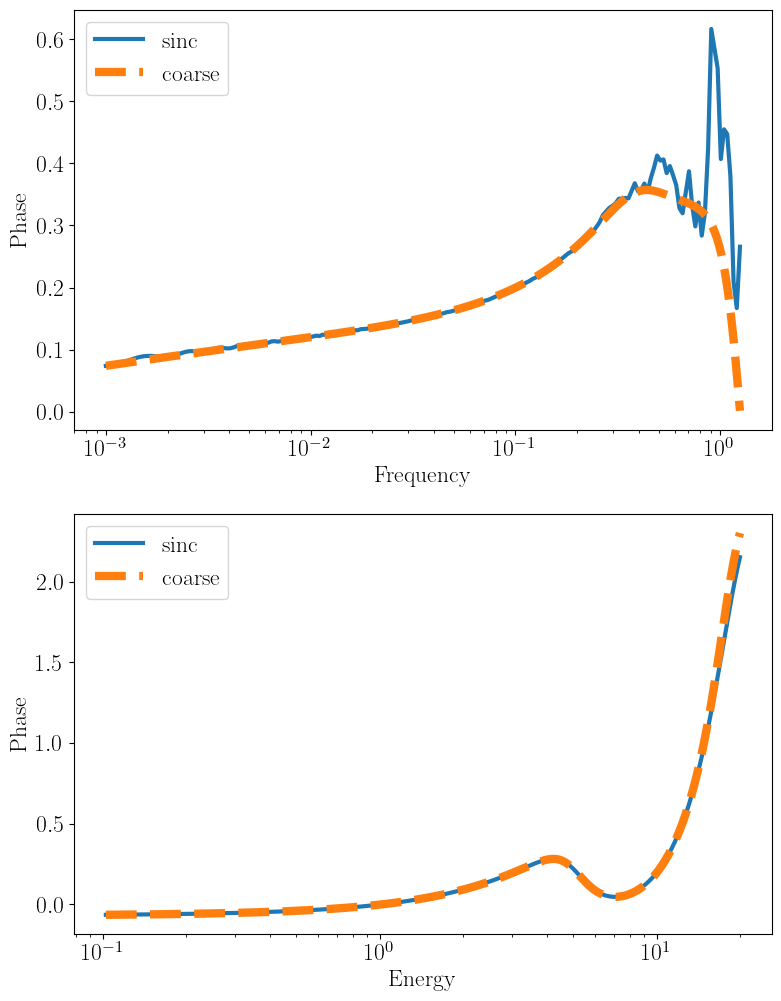

In [9]:
fig, ((ax1),(ax2)) = plt.subplots(2,1,figsize=(9.,12.))

ax1.plot(cross_sinc.freqs,cross_sinc.phase_frequency(bounds),
         lw=3,label='sinc')
ax1.plot(cross_fft.freqs,cross_fft.phase_frequency(bounds),
         lw=6,linestyle='dashed',label='coarse')
ax1.set_xscale("log")
ax1.set_xlabel("Frequency")
ax1.set_ylabel("Phase")
ax1.legend()

min = 0.1*cross_sinc.freqs[-1]
max = cross_sinc.freqs[-1]

ax2.plot(cross_sinc.energ,cross_sinc.phase_energy(nu_min=min,nu_max=max),
         lw=3,label='sinc')
ax2.plot(cross_fft.energ,cross_fft.phase_energy(nu_min=min,nu_max=max),
         lw=6,linestyle='dashed',label='coarse')
ax2.set_xscale("log")
ax2.set_xlabel("Energy")
ax2.set_ylabel("Phase")
ax2.legend()

Finally, we can run a simple benchmark to compare the performance of the sinc and fft methods - for most model setups, the sinc method will be faster by a factor of a few, while also providing good numerical resolution over multiple orders of magnitude in Frequency and/or time. 

Instead of using the sinc decomposition method, we can also use a FFT and then interpolate our cross spectrum over a logarthmically spaced grid. We can use the ````rebin_frequency```` method to accomplish this, however a simple benchmark shows that the computational cost is much larger than the sinc method. The advantage of using an FFT+interpolation is that the numerical noise near the Nyquist frequency is not present. As with other features presented in this notebook, it is up to the users to choose the most appropriate grids and computational methods for each use case.

77.1 ms ± 9.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
125 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
320 ms ± 3.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


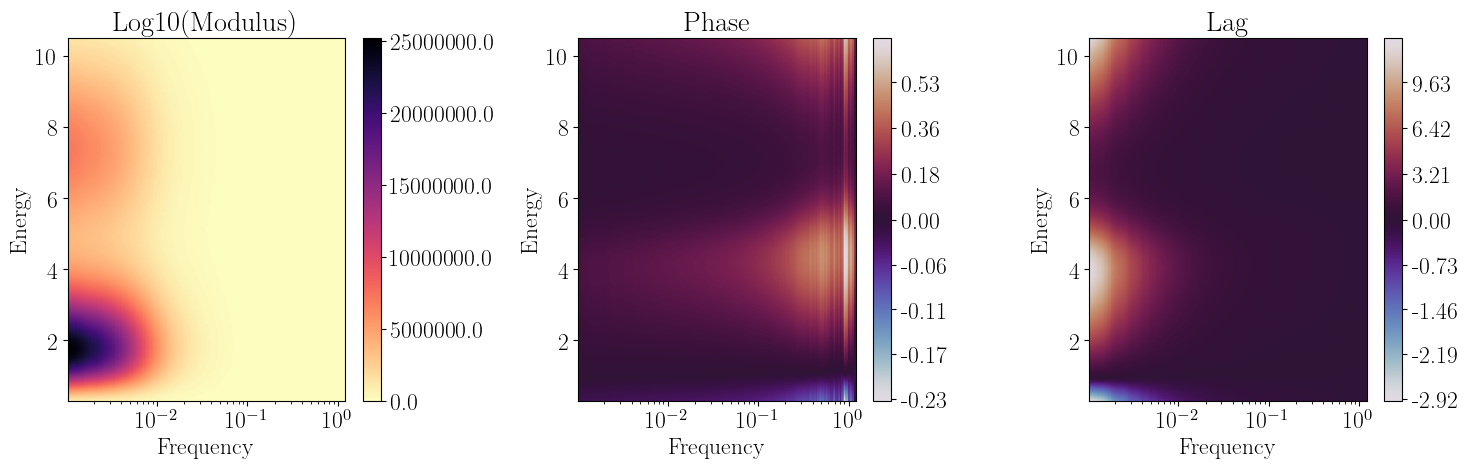

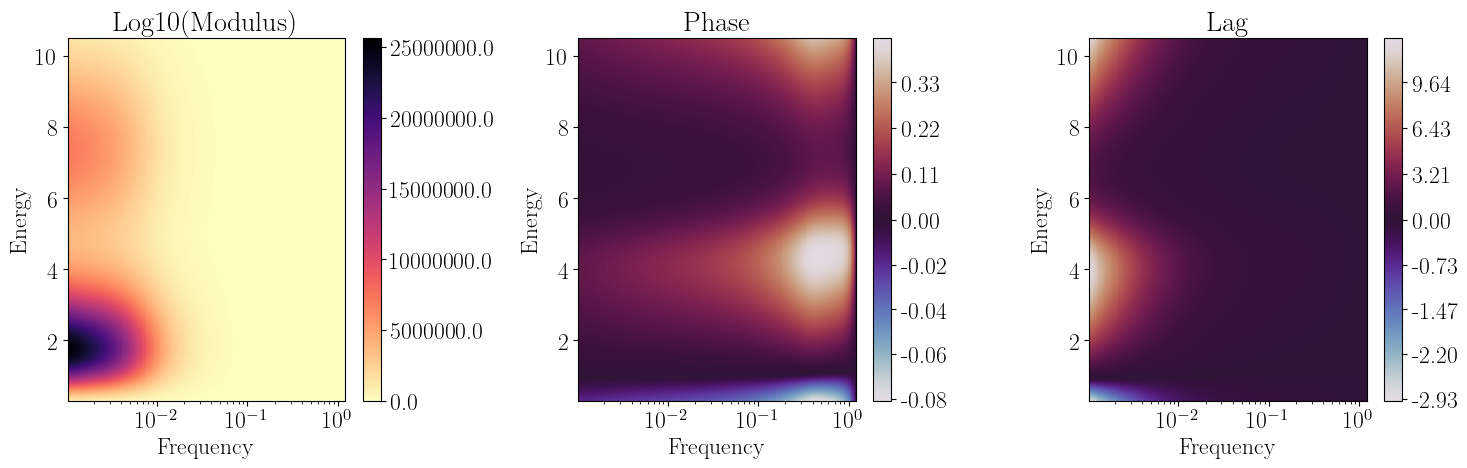

In [10]:
#benchmark fft vs sinc vs fft+interp - note that the second is much slower
%timeit cross_sinc.cross_from_irf()
%timeit cross_fft.cross_from_irf()
%timeit cross_fft.rebin_frequency(cross_sinc.freqs)

#however it can in principle deal with the numerical issues above quite well 
cross_sinc.plot_cross_2d()
cross_fft.plot_cross_2d()